In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os
from dotenv import load_dotenv


In [3]:
from pymongo import MongoClient

load_dotenv()
client = os.getenv("MONGO_URL")
client = MongoClient(client)
db = client["storage_simulation"]
collection = db["usage_logs"]



In [11]:
def load_and_preprocess_data() -> Dict[str, dict]:
    """Load and preprocess data with proper feature engineering"""
    raw_data = pd.DataFrame(list(collection.find()))
    raw_data = raw_data.drop(columns=['_id'])
    raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

    print("\n🔍 Data Diagnostics:")
    print(f"Total records: {len(raw_data)}")
    print("Unique directories:", raw_data['directory'].unique())

    processed = {}
    for directory in raw_data['directory'].unique():
        df = raw_data[raw_data['directory'] == directory].copy()
        df = df.sort_values('timestamp').set_index('timestamp')

        df = df[['storage_gb']]

        # Scale storage_gb
        scaler = MinMaxScaler()
        df['scaled_gb'] = scaler.fit_transform(df[['storage_gb']])

        processed[directory] = df[['storage_gb']]


    return processed

In [7]:
def create_sequences_singlestep(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])  # Just one value
    return np.array(X), np.array(y)

In [8]:
def build_lstm_model_singlestep(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        Dropout(0.25),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [12]:
def train_single_step_forecast_model(df, dir_name, sequence_length=96):

    print(f"\n📁 Processing directory: {dir_name} (Single-Step Forecast)")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.values).flatten()


    X, y = create_sequences_singlestep(scaled_data, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM expects 3D
    y = y.reshape(-1, 1)

    # Step 3: Train-test split
    split_idx = int(len(X) * 0.8)
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model_singlestep(input_shape)

    # Step 5: Training
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0
    )

    # Step 6: Prediction
    y_pred = model.predict(X_test)
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test)

    # Step 7: Metrics
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    data_range = y_test_original.max() - y_test_original.min()
    nmae = mae / data_range
    nrmse = rmse / data_range

    print(f"📊 {dir_name.upper()} - MAE: {mae:.2f} GB")
    print(f"📊 {dir_name.upper()} - RMSE: {rmse:.2f} GB")
    print(f"📊 {dir_name.upper()} - Normalized MAE: {nmae:.4f}")
    print(f"📊 {dir_name.upper()} - Normalized RMSE: {nrmse:.4f}")
    print("-" * 50)

    # Step 8: Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_original, label='Actual')
    plt.plot(y_pred_original, label='Predicted')
    plt.title(f"{dir_name.upper()} - Single-Step Forecast (Next Day End)")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Storage (GB)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    safe_name = dir_name.strip("/")  # removes leading slash


    models = os.path.abspath(os.path.join(os.getcwd(), '..', 'models'))
    os.makedirs(models, exist_ok=True)
    model.save(os.path.join(models, f"{safe_name}_daily_forecast_model.keras"))

    scalers = os.path.abspath(os.path.join(os.getcwd(), '..', 'scalers'))
    os.makedirs(scalers, exist_ok=True)
    scaler_file_path = os.path.join(scalers, f"{safe_name}_daily_scaler.pkl")
    joblib.dump(scaler, scaler_file_path)




🔍 Data Diagnostics:
Total records: 302484
Unique directories: ['/scratch' '/projects' '/customer' '/info']

📁 Processing directory: /scratch (Single-Step Forecast)
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
📊 /SCRATCH - MAE: 9.61 GB
📊 /SCRATCH - RMSE: 12.57 GB
📊 /SCRATCH - Normalized MAE: 0.0056
📊 /SCRATCH - Normalized RMSE: 0.0074
--------------------------------------------------


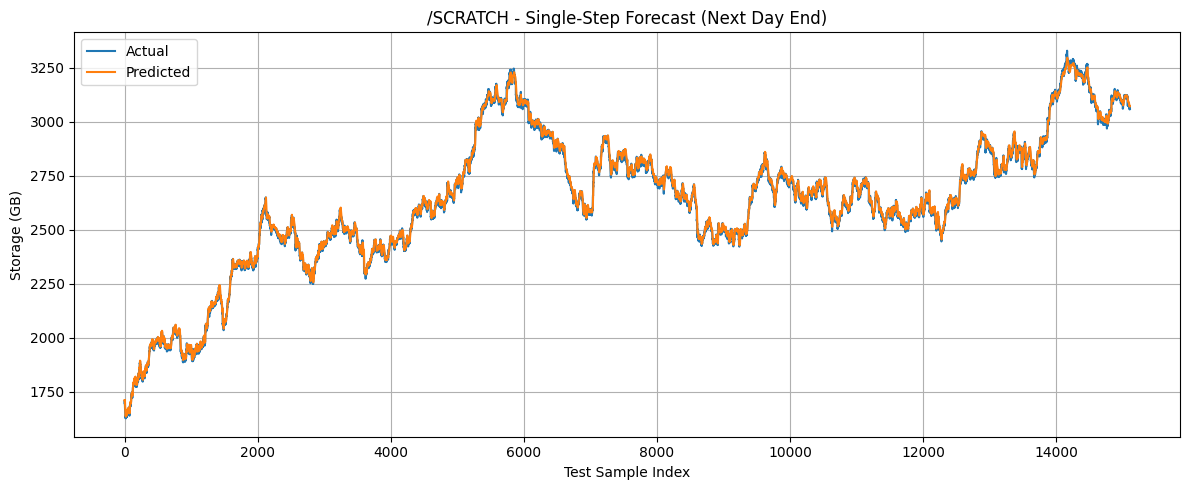


📁 Processing directory: /projects (Single-Step Forecast)
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
📊 /PROJECTS - MAE: 16.11 GB
📊 /PROJECTS - RMSE: 19.65 GB
📊 /PROJECTS - Normalized MAE: 0.0175
📊 /PROJECTS - Normalized RMSE: 0.0214
--------------------------------------------------


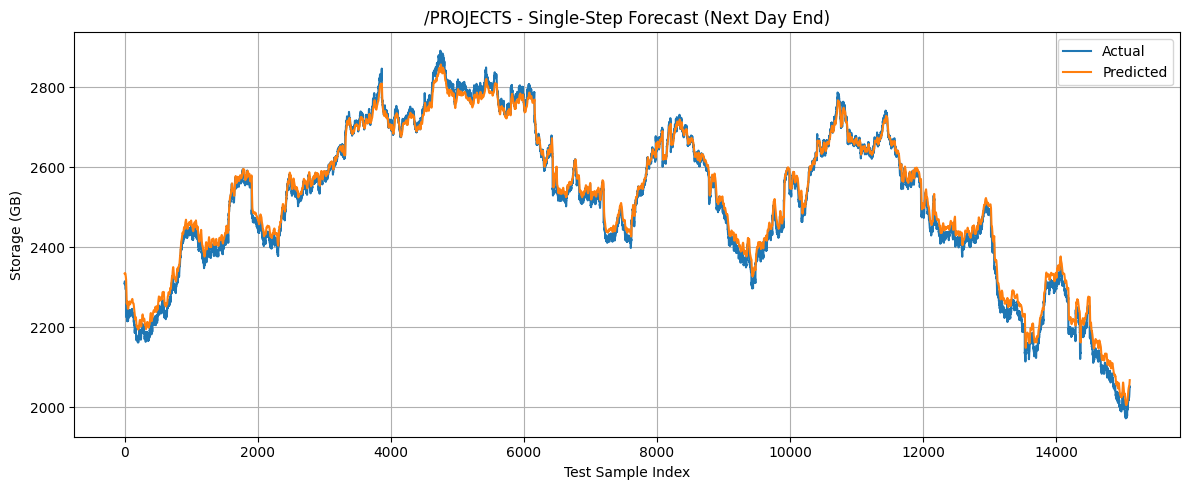


📁 Processing directory: /customer (Single-Step Forecast)
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
📊 /CUSTOMER - MAE: 6.16 GB
📊 /CUSTOMER - RMSE: 9.59 GB
📊 /CUSTOMER - Normalized MAE: 0.0154
📊 /CUSTOMER - Normalized RMSE: 0.0240
--------------------------------------------------


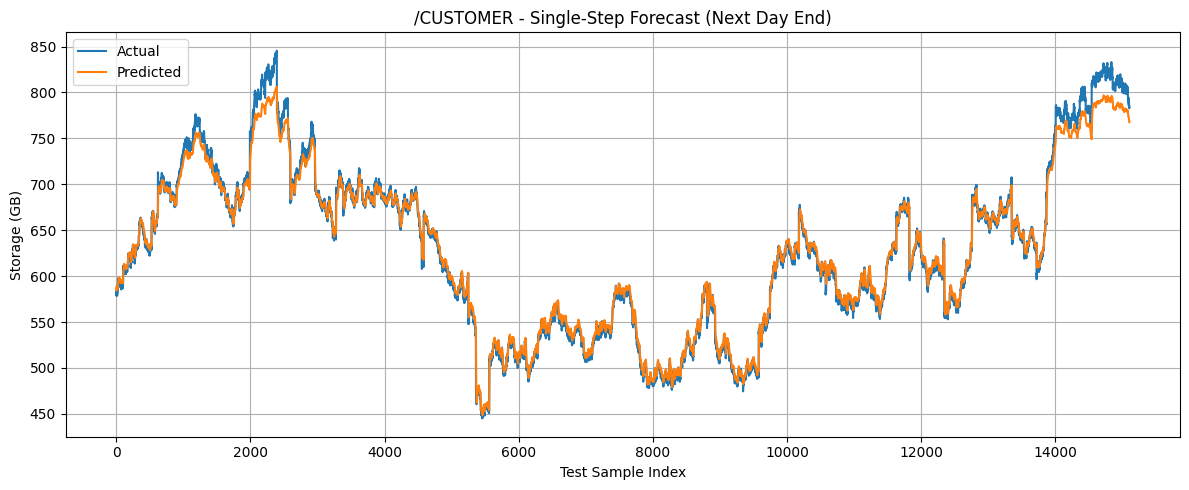


📁 Processing directory: /info (Single-Step Forecast)
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
📊 /INFO - MAE: 3.42 GB
📊 /INFO - RMSE: 5.17 GB
📊 /INFO - Normalized MAE: 0.0095
📊 /INFO - Normalized RMSE: 0.0143
--------------------------------------------------


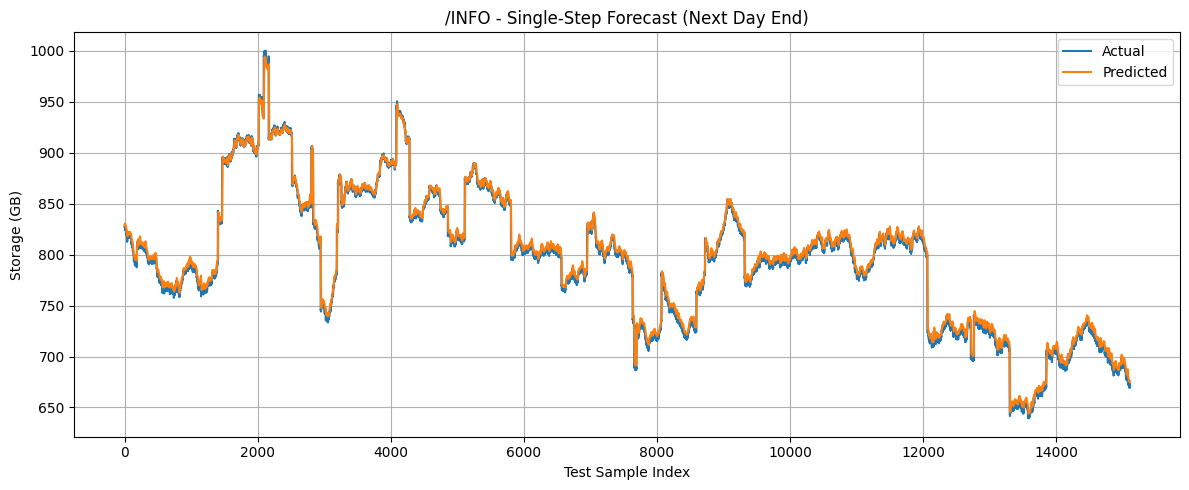

In [13]:
data_dict = load_and_preprocess_data()
for name, data in data_dict.items():
  train_single_step_forecast_model(data,name)